In [1]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

In [4]:
from src.config import (
    DATA_DIR,
    RESULTS_DIR,
)

from src.plotting import (
    set_plot_style
)

set_plot_style()

In [5]:
df = pd.read_csv(DATA_DIR / "cleaned" / "cleaned_monthly_panel.csv")

In [6]:
from src.features import build_panel_features

X_m, y_m, meta_m = build_panel_features(
    panel_df=df,
    target="HospRisk",
    group_col="State",
    date_col="Date",
    freq="MS",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewm_spans=(3, 6, 12),
    dropna=True,
)

X_m.head(), y_m.head(), meta_m.head()


(   year  month  quarter  month_sin     month_cos  HospRisk_lag1  \
 0  2016      1        1   0.500000  8.660254e-01       0.604047   
 1  2016      2        1   0.866025  5.000000e-01       1.458312   
 2  2016      3        1   1.000000  6.123234e-17       0.854744   
 3  2016      4        2   0.866025 -5.000000e-01       0.854186   
 4  2016      5        2   0.500000 -8.660254e-01       1.052368   
 
    HospRisk_lag2  HospRisk_lag3  HospRisk_lag6  HospRisk_lag12  \
 0       0.907441       1.313065       1.268649        0.714760   
 1       0.604047       0.907441       1.164498        0.765072   
 2       1.458312       0.604047       0.758802        1.123538   
 3       0.854744       1.458312       1.313065        1.070064   
 4       0.854186       0.854744       0.907441        1.168046   
 
    HospRisk_rollmean3  HospRisk_rollmean6  HospRisk_rollmean12  HospRisk_ewm3  \
 0            0.941518            1.002750             0.993696       0.813459   
 1            0.989934

In [7]:
from src.RQ1_utils import (
    yearly_train_ends, 
    rolling_origin_masks,
    summarize_metrics_mean_std,
    plot_stability_across_splits,
    plot_fit_and_forecast,
    plot_rmse_per_fold,
    
)

In [8]:
train_ends = yearly_train_ends(meta_m, date_col="Date")
splits = rolling_origin_masks(meta_m, date_col="Date", train_ends=train_ends, test_size=12)

len(train_ends), len(splits)

(9, 8)

In [9]:
split_calendar = pd.DataFrame([
    {
        "train_end": s["train_end"].date(),
        "test_start": s["test_start"].date(),
        "test_end": s["test_end"].date(),
        "train_weeks": s["n_train_weeks"],
        "test_weeks": s["n_test_weeks"],
        "train_rows": s["n_train_rows"],
        "test_rows": s["n_test_rows"],
    }
    for s in splits
])

split_calendar.head(10)


,train_end,test_start,test_end,train_weeks,test_weeks,train_rows,test_rows
0,2016-12-01,2017-01-01,2017-12-01,12,12,360,360
1,2017-12-01,2018-01-01,2018-12-01,24,12,720,360
2,2018-12-01,2019-01-01,2019-12-01,36,12,1080,360
3,2019-12-01,2020-01-01,2020-12-01,48,12,1440,360
4,2020-12-01,2021-01-01,2021-12-01,60,12,1800,360
5,2021-12-01,2022-01-01,2022-12-01,72,12,2160,360
6,2022-12-01,2023-01-01,2023-12-01,84,12,2520,360
7,2023-12-01,2024-01-01,2024-12-01,96,12,2880,360


In [10]:
# train_end dates to keep
keep_train_ends = {
    pd.Timestamp("2018-12-01"),
    pd.Timestamp("2019-12-01"),
    pd.Timestamp("2020-12-01"),
    pd.Timestamp("2021-12-01"),
    pd.Timestamp("2022-12-01"),
    pd.Timestamp("2023-12-01"),
}

# filter splits
splits_origins = [
    s for s in splits
    if pd.Timestamp(s["train_end"]) in keep_train_ends
]

len(splits_origins), [s["train_end"].date() for s in splits_origins]


(6,
 [datetime.date(2018, 12, 1),
  datetime.date(2019, 12, 1),
  datetime.date(2020, 12, 1),
  datetime.date(2021, 12, 1),
  datetime.date(2022, 12, 1),
  datetime.date(2023, 12, 1)])

In [11]:
from src.RQ1_utils import run_local

In [12]:
horizons = [1, 3, 6]

preds_local, metrics_local, perm_local = run_local(
    X=X_m,
    y=y_m,
    meta=meta_m,
    splits=splits_origins,
    horizons=horizons,
    group_col="State",
    date_col="Date",
    seasonal_period=12,
    use_linear=True,
    use_tree=True,
    compute_perm_importance=True,          
    savedir=RESULTS_DIR,          
    run_name="monthly_lobal_no_exg",
)



In [17]:
metrics_local.columns


Index(['split_id', 'train_end', 'horizon', 'model', 'set', 'n_rows', 'MAE',
       'RMSE', 'MASE'],
      dtype='object')

In [18]:
metrics_local['split_id'].value_counts()

split_id
1    45
2    45
3    45
4    45
5    45
6    45
Name: count, dtype: int64

In [19]:
metrics_local.query("set == 'test'").sort_values(["train_end","horizon","MASE"]).head(20)


,split_id,train_end,horizon,model,set,n_rows,MAE,RMSE,MASE
12,1,2018-12-01,1,LightGBM,test,360,0.217271,0.290257,0.739703
14,1,2018-12-01,1,CatBoost,test,360,0.228224,0.314147,0.773172
10,1,2018-12-01,1,XGBoost,test,360,0.251623,0.350909,0.836347
0,1,2018-12-01,1,Seasonal Naive,test,360,0.302429,0.419733,0.990162
2,1,2018-12-01,1,Ridge,test,360,0.298159,0.411519,0.996130
4,1,2018-12-01,1,Lasso,test,360,0.351219,0.514099,1.134543
8,1,2018-12-01,1,PLS,test,360,0.345310,0.478141,1.144172
6,1,2018-12-01,1,ElasticNet,test,360,0.357036,0.517780,1.160300
27,1,2018-12-01,3,LightGBM,test,360,0.224997,0.297359,0.776004
29,1,2018-12-01,3,CatBoost,test,360,0.233089,0.319141,0.795935


In [20]:
preds_local['State'].value_counts()

State
ALABAMA                 9964
ARKANSAS                9964
COLORADO                9964
CONNECTICUT             9964
DELAWARE                9964
DISTRICT OF COLUMBIA    9964
FLORIDA                 9964
GEORGIA                 9964
IDAHO                   9964
ILLINOIS                9964
KANSAS                  9964
LOUISIANA               9964
MAINE                   9964
MASSACHUSETTS           9964
MISSISSIPPI             9964
MISSOURI                9964
MONTANA                 9964
NEBRASKA                9964
NEW HAMPSHIRE           9964
NEW JERSEY              9964
NEW YORK                9964
NORTH DAKOTA            9964
OHIO                    9964
OKLAHOMA                9964
PENNSYLVANIA            9964
RHODE ISLAND            9964
SOUTH DAKOTA            9964
TEXAS                   9964
WEST VIRGINIA           9964
WISCONSIN               9964
Name: count, dtype: int64

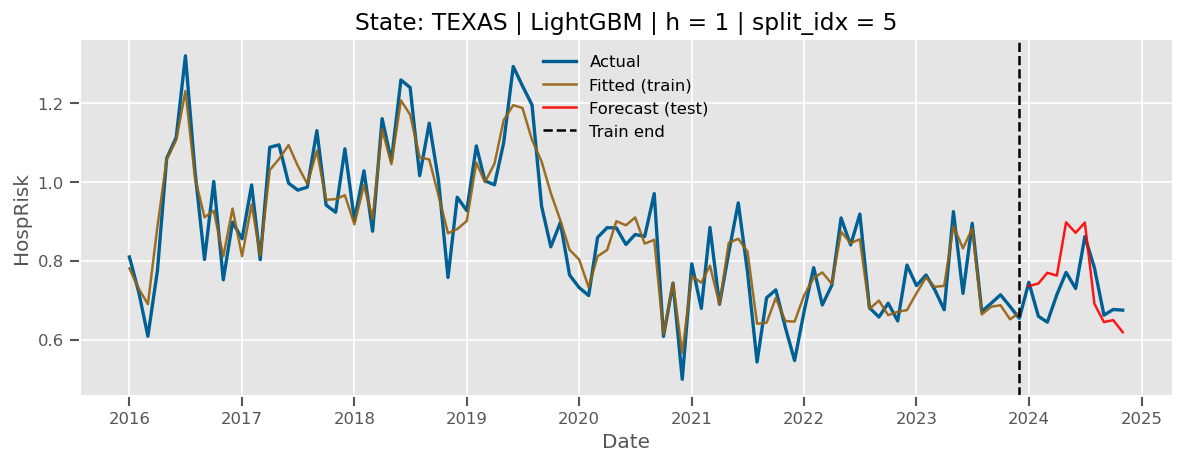

In [22]:
from src.RQ1_utils import plot_fit_and_forecast

plot_fit_and_forecast(preds_local, model='LightGBM', split_idx=5, state="TEXAS", horizon=1)

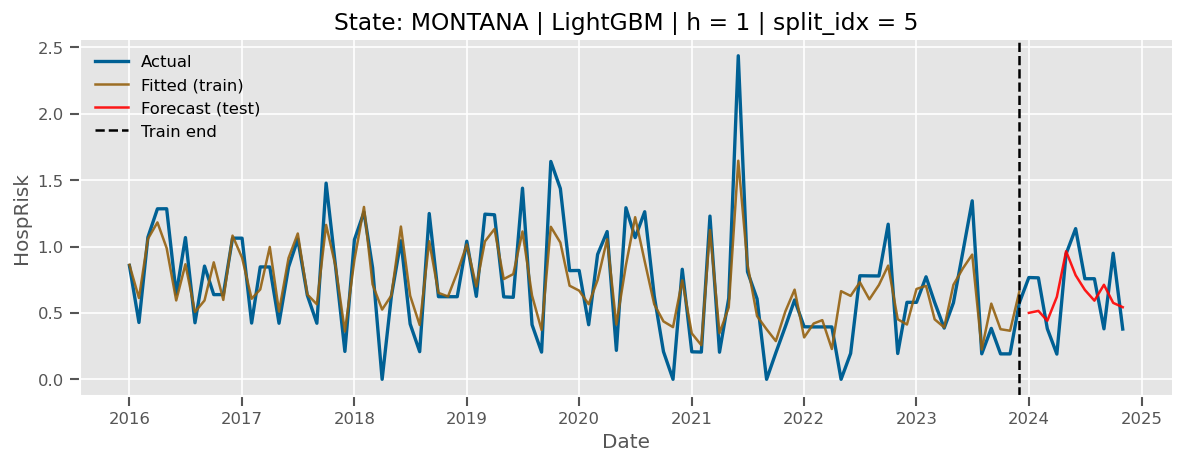

In [23]:

plot_fit_and_forecast(preds_local, model='LightGBM', split_idx=5, state="MONTANA", horizon=1)

In [25]:

import numpy as np

def compute_metrics_state_level(preds_df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns metrics at: State x split_id x train_end x horizon x model x set
    """
    df = preds_df.copy()

    # error columns
    err = df["y_true"] - df["y_pred"]
    df["_ae"] = err.abs()
    df["_se"] = err.pow(2)
    # per-row MASE using provided per-row scale
    # (avoid div by zero)
    df["_mase"] = df["_ae"] / df["mase_scale"].replace(0, np.nan)

    gcols = ["State", "split_id", "train_end", "horizon", "model", "set"]
    out = (
        df.groupby(gcols, as_index=False)
          .agg(
              n=("y_true", "size"),
              mae=("_ae", "mean"),
              rmse=("_se", lambda x: float(np.sqrt(np.mean(x)))),
              mase=("_mase", "mean"),
          )
    )
    return out


In [26]:
state_metrics = compute_metrics_state_level(preds_local)

In [28]:
state_metrics.query("set == 'test'").head()

,State,split_id,train_end,horizon,model,set,n,mae,rmse,mase
0,ALABAMA,1,2018-12-01,1,CatBoost,test,12,0.192100,0.274749,0.576705
2,ALABAMA,1,2018-12-01,1,ElasticNet,test,12,0.368414,0.432646,1.106016
4,ALABAMA,1,2018-12-01,1,Lasso,test,12,0.341977,0.407578,1.026652
6,ALABAMA,1,2018-12-01,1,LightGBM,test,12,0.161280,0.191425,0.484180
8,ALABAMA,1,2018-12-01,1,PLS,test,12,0.444418,0.508309,1.334189


In [29]:
from src.config import RESULTS_DIR

In [47]:
global_preds = pd.read_csv(RESULTS_DIR / 'monthly_global_no_exg' / 'preds.csv', parse_dates=['Date', 'train_end'])


In [48]:
global_test = global_preds.query("set == 'test'")

In [49]:
global_test = global_test[global_test['model'] != 'Seasonal Naive']

In [52]:
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def compute_metrics_from_preds_state(preds_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    gcols = ["State", "split_id", "train_end", "horizon", "model", "set"]

    for keys, g in preds_df.groupby(gcols, sort=True):
        state, split_id, train_end, h, model, set_name = keys

        rows.append({
            "State": state,
            "split_id": int(split_id),
            "train_end": pd.to_datetime(train_end),
            "horizon": int(h),
            "model": model,
            "set": set_name,
            "n_rows": int(len(g)),
            "MAE": float(mean_absolute_error(g["y_true"], g["y_pred"])),
            "RMSE": float(root_mean_squared_error(g["y_true"], g["y_pred"])),
        })

    return pd.DataFrame(rows)


In [53]:
global_metrics_state = compute_metrics_from_preds_state(global_test)
global_metrics_state.head()


,State,split_id,train_end,horizon,model,set,n_rows,MAE,RMSE
0,ALABAMA,1,2018-12-01,1,CatBoost,test,12,0.189504,0.252108
1,ALABAMA,1,2018-12-01,1,ElasticNet,test,12,0.177472,0.217195
2,ALABAMA,1,2018-12-01,1,Lasso,test,12,0.174634,0.214691
3,ALABAMA,1,2018-12-01,1,LightGBM,test,12,0.222604,0.263750
4,ALABAMA,1,2018-12-01,1,PLS,test,12,0.181619,0.216174


In [54]:
def aggregate_across_states(
    state_metrics: pd.DataFrame,
    *,
    weight_by_n: bool = False,
) -> pd.DataFrame:
    """
    Aggregates State-level metrics into a single row per:
    split_id x train_end x horizon x model x set
    """
    gcols = ["split_id", "train_end", "horizon", "model", "set"]

    if not weight_by_n:
        return (
            state_metrics
            .groupby(gcols, as_index=False)
            .agg(
                n_states=("State", "nunique"),
                n=("n", "sum"),
                mae=("mae", "mean"),
                rmse=("rmse", "mean"),
                mase=("mase", "mean"),
            )
        )

    # weighted by n
    def wavg(x, col):
        w = x["n"].to_numpy()
        v = x[col].to_numpy()
        if w.sum() == 0:
            return np.nan
        return float(np.average(v, weights=w))

    return (
        state_metrics
        .groupby(gcols, as_index=False)
        .apply(lambda x: pd.Series({
            "n_states": x["State"].nunique(),
            "n": int(x["n"].sum()),
            "mae": wavg(x, "mae"),
            "rmse": wavg(x, "rmse"),
            "mase": wavg(x, "mase"),
        }))
        .reset_index(drop=True)
    )


In [55]:
m_split_local = aggregate_across_states(state_metrics)

In [58]:
m_split_local.query("set == 'test' and model == 'Lasso'")

,split_id,train_end,horizon,model,set,n_states,n,mae,rmse,mase
4,1,2018-12-01,1,Lasso,test,30,360,0.351219,0.411773,1.134543
19,1,2018-12-01,3,Lasso,test,30,360,0.288722,0.356469,1.013493
34,1,2018-12-01,6,Lasso,test,30,360,0.295182,0.351405,1.021362
49,2,2019-12-01,1,Lasso,test,30,360,0.334449,0.387863,1.173030
64,2,2019-12-01,3,Lasso,test,30,360,0.291266,0.345787,1.023358
79,2,2019-12-01,6,Lasso,test,30,360,0.287945,0.348383,0.990872
94,3,2020-12-01,1,Lasso,test,30,360,0.274258,0.333395,0.900662
109,3,2020-12-01,3,Lasso,test,30,360,0.255222,0.310267,0.853701
124,3,2020-12-01,6,Lasso,test,30,360,0.249003,0.302416,0.825523
139,4,2021-12-01,1,Lasso,test,30,360,0.237194,0.293515,0.772049


In [59]:
m_split_local.query("set == 'test' and model == 'CatBoost'")

,split_id,train_end,horizon,model,set,n_states,n,mae,rmse,mase
0,1,2018-12-01,1,CatBoost,test,30,360,0.228224,0.282128,0.773172
15,1,2018-12-01,3,CatBoost,test,30,360,0.233089,0.284031,0.795935
30,1,2018-12-01,6,CatBoost,test,30,360,0.243798,0.290868,0.858935
45,2,2019-12-01,1,CatBoost,test,30,360,0.284544,0.333381,0.952794
60,2,2019-12-01,3,CatBoost,test,30,360,0.275860,0.327496,0.938147
75,2,2019-12-01,6,CatBoost,test,30,360,0.289468,0.337254,0.988222
90,3,2020-12-01,1,CatBoost,test,30,360,0.252387,0.307518,0.844570
105,3,2020-12-01,3,CatBoost,test,30,360,0.235609,0.284232,0.810282
120,3,2020-12-01,6,CatBoost,test,30,360,0.235910,0.287636,0.793177
135,4,2021-12-01,1,CatBoost,test,30,360,0.216022,0.262835,0.718734


In [60]:
def summarize_local_metrics_mean_std(
    local_split_metrics: pd.DataFrame,
    horizon: int,
) -> pd.DataFrame:
    """
    Summarize TEST performance for a given horizon (LOCAL, after aggregating across states).

    Input: local_split_metrics should be the output of aggregate_across_states(...),
           i.e. one row per split_id x train_end x horizon x model x set,
           with metric columns: rmse, mae, mase (lowercase).

    Output: index=models, columns RMSE/MAE/MASE formatted as mean ± std across splits.
    """

    df = (
        local_split_metrics
        .query("set == 'test' and horizon == @horizon")
        .loc[:, ["model", "rmse", "mae", "mase"]]
        .copy()
    )

    summary = (
        df.groupby("model")
          .agg(
              RMSE_mean=("rmse", "mean"),
              RMSE_std=("rmse", "std"),
              MAE_mean=("mae", "mean"),
              MAE_std=("mae", "std"),
              MASE_mean=("mase", "mean"),
              MASE_std=("mase", "std"),
          )
    )

    out = pd.DataFrame({
        "RMSE": summary.apply(lambda r: f"{r.RMSE_mean:.3f} ± {r.RMSE_std:.3f}", axis=1),
        "MAE":  summary.apply(lambda r: f"{r.MAE_mean:.3f} ± {r.MAE_std:.3f}", axis=1),
        "MASE": summary.apply(lambda r: f"{r.MASE_mean:.3f} ± {r.MASE_std:.3f}", axis=1),
    })

    return out.sort_index()


In [61]:
local_m1 = summarize_local_metrics_mean_std(state_metrics, horizon=1)

local_m1

,RMSE,MAE,MASE
model,,,
CatBoost,0.283 ± 0.163,0.234 ± 0.139,0.793 ± 0.222
ElasticNet,0.326 ± 0.219,0.273 ± 0.195,0.920 ± 0.453
Lasso,0.322 ± 0.218,0.269 ± 0.194,0.905 ± 0.439
LightGBM,0.278 ± 0.155,0.231 ± 0.133,0.783 ± 0.216
PLS,0.322 ± 0.203,0.268 ± 0.178,0.912 ± 0.422
Ridge,0.305 ± 0.187,0.254 ± 0.163,0.865 ± 0.380
Seasonal Naive,0.341 ± 0.191,0.276 ± 0.155,0.941 ± 0.260
XGBoost,0.300 ± 0.176,0.245 ± 0.150,0.825 ± 0.216


In [62]:
local_m3 = summarize_local_metrics_mean_std(state_metrics, horizon=3)

local_m3

,RMSE,MAE,MASE
model,,,
CatBoost,0.282 ± 0.152,0.229 ± 0.125,0.789 ± 0.213
ElasticNet,0.302 ± 0.175,0.248 ± 0.149,0.855 ± 0.334
Lasso,0.298 ± 0.174,0.245 ± 0.147,0.840 ± 0.310
LightGBM,0.281 ± 0.155,0.230 ± 0.130,0.788 ± 0.218
PLS,0.305 ± 0.175,0.252 ± 0.148,0.870 ± 0.335
Ridge,0.288 ± 0.163,0.236 ± 0.136,0.815 ± 0.292
Seasonal Naive,0.340 ± 0.191,0.275 ± 0.153,0.938 ± 0.254
XGBoost,0.300 ± 0.164,0.244 ± 0.134,0.840 ± 0.234


In [63]:
local_m6 = summarize_local_metrics_mean_std(state_metrics, horizon=6)

local_m6

,RMSE,MAE,MASE
model,,,
CatBoost,0.283 ± 0.158,0.235 ± 0.133,0.810 ± 0.244
ElasticNet,0.300 ± 0.194,0.249 ± 0.167,0.843 ± 0.361
Lasso,0.297 ± 0.193,0.247 ± 0.167,0.833 ± 0.355
LightGBM,0.278 ± 0.159,0.229 ± 0.134,0.784 ± 0.229
PLS,0.301 ± 0.194,0.250 ± 0.168,0.853 ± 0.381
Ridge,0.289 ± 0.181,0.240 ± 0.154,0.818 ± 0.331
Seasonal Naive,0.337 ± 0.192,0.272 ± 0.154,0.926 ± 0.266
XGBoost,0.292 ± 0.162,0.243 ± 0.138,0.845 ± 0.278


In [104]:
local_m1.to_csv(RESULTS_DIR / 'monthly_local_no_exg' / 'local_m1.csv')
local_m3.to_csv(RESULTS_DIR / 'monthly_local_no_exg' / 'local_m3.csv')
local_m6.to_csv(RESULTS_DIR / 'monthly_local_no_exg' / 'local_m6.csv')

In [69]:
global_metrics = pd.read_csv(RESULTS_DIR / 'monthly_global_no_exg' / 'metrics.csv')

In [64]:
def prepare_paired_metrics(
    global_metrics: pd.DataFrame,
    local_metrics: pd.DataFrame,
    *,
    horizon: int,
    model: str,
    metric: str,   # "RMSE", "MAE", or "MASE"
) -> pd.DataFrame:
    """
    Returns a dataframe with one row per split_id:
      split_id | global | local | diff
    """

    g = (
        global_metrics
        .query("set == 'test' and horizon == @horizon and model == @model")
        .loc[:, ["split_id", metric]]
        .rename(columns={metric: "global"})
    )

    l = (
        local_metrics
        .query("set == 'test' and horizon == @horizon and model == @model")
        .loc[:, ["split_id", metric.lower()]]
        .rename(columns={metric.lower(): "local"})
    )

    df = g.merge(l, on="split_id", how="inner").sort_values("split_id")
    df["diff"] = df["local"] - df["global"]

    return df


In [66]:
from scipy.stats import wilcoxon

In [65]:
def wilcoxon_local_vs_global(
    paired_df: pd.DataFrame,
    *,
    alternative: str = "two-sided",  # "less" = local < global
) -> dict:
    """
    Runs Wilcoxon signed-rank test on paired split-level metrics.
    """

    x = paired_df["local"].to_numpy()
    y = paired_df["global"].to_numpy()

    if len(x) < 5:
        raise ValueError("Too few splits for a meaningful Wilcoxon test.")

    stat, pval = wilcoxon(
        x,
        y,
        alternative=alternative,
        zero_method="wilcox",  # drop zero diffs
    )

    return {
        "n_splits": len(x),
        "statistic": float(stat),
        "p_value": float(pval),
        "median_diff": float(paired_df["diff"].median()),
        "mean_diff": float(paired_df["diff"].mean()),
    }


Index(['Date', 'State', 'split_id', 'train_end', 'horizon', 'set', 'model',
       'y_true', 'y_pred', 'mase_scale'],
      dtype='object')

In [93]:

paired = prepare_paired_metrics(
    global_metrics=global_metrics,
    local_metrics=state_metrics,
    horizon=6,
    model="LightGBM",
    metric="RMSE",
)

result = wilcoxon_local_vs_global(paired, alternative='less')
result




{'n_splits': 180,
 'statistic': 6389.0,
 'p_value': 0.006063548251362936,
 'median_diff': -0.04641302877291044,
 'mean_diff': -0.012858629558079078}

In [94]:
def prepare_paired_models(
    metrics_df: pd.DataFrame,
    *,
    horizon: int,
    model_a: str,
    model_b: str,
    metric: str,   # "rmse", "mae", or "mase"
    set_name: str = "test",
) -> pd.DataFrame:
    """
    Returns:
      split_id | model_a | model_b | diff (A - B)
    """

    a = (
        metrics_df
        .query("set == @set_name and horizon == @horizon and model == @model_a")
        .loc[:, ["split_id", metric]]
        .rename(columns={metric: "A"})
    )

    b = (
        metrics_df
        .query("set == @set_name and horizon == @horizon and model == @model_b")
        .loc[:, ["split_id", metric]]
        .rename(columns={metric: "B"})
    )

    df = (
        a.merge(b, on="split_id", how="inner")
         .sort_values("split_id")
         .reset_index(drop=True)
    )

    df["diff"] = df["A"] - df["B"]
    return df


In [95]:
from scipy.stats import wilcoxon

def wilcoxon_two_models(
    paired_df: pd.DataFrame,
    *,
    alternative: str = "two-sided",  # "less" means A < B
) -> dict:

    x = paired_df["A"].to_numpy()
    y = paired_df["B"].to_numpy()

    if len(x) < 5:
        raise ValueError("Too few splits for a meaningful Wilcoxon test.")

    stat, pval = wilcoxon(
        x,
        y,
        alternative=alternative,
        zero_method="wilcox",  # drop zero diffs
    )

    return {
        "n_splits": len(x),
        "statistic": float(stat),
        "p_value": float(pval),
        "median_diff": float(paired_df["diff"].median()),
        "mean_diff": float(paired_df["diff"].mean()),
    }


In [103]:
paired = prepare_paired_models(
    state_metrics,
    horizon=6,
    model_a="LightGBM",
    model_b="CatBoost",
    metric="rmse",
)

res = wilcoxon_two_models(paired, alternative="less")
res


{'n_splits': 5400,
 'statistic': 7059522.0,
 'p_value': 0.021510248151505516,
 'median_diff': -0.007440760650843731,
 'mean_diff': -0.005009310234711081}

In [105]:
from src.RQ1_utils import plot_fit_and_forecast

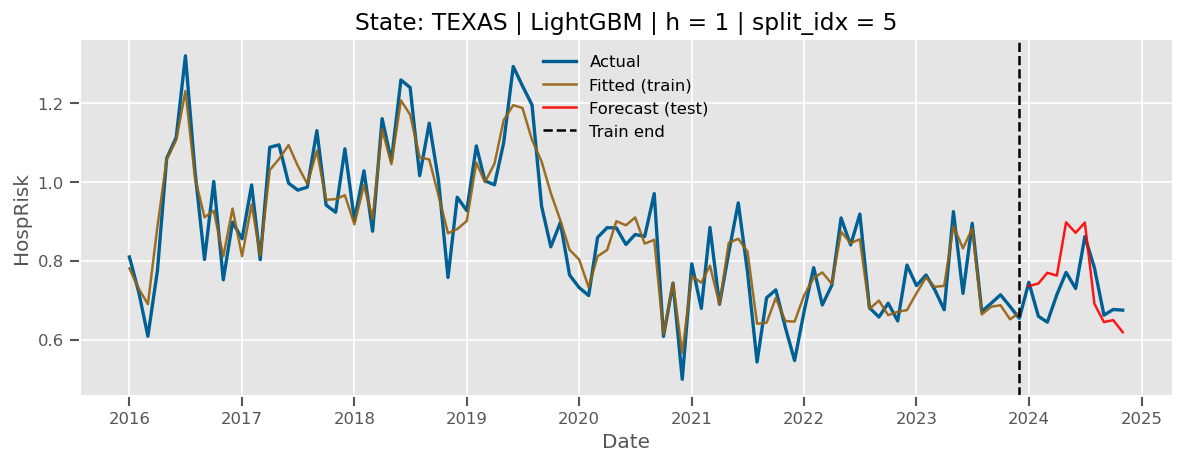

In [106]:
plot_fit_and_forecast(preds_local, model='LightGBM', split_idx=5, horizon=1, state='TEXAS')

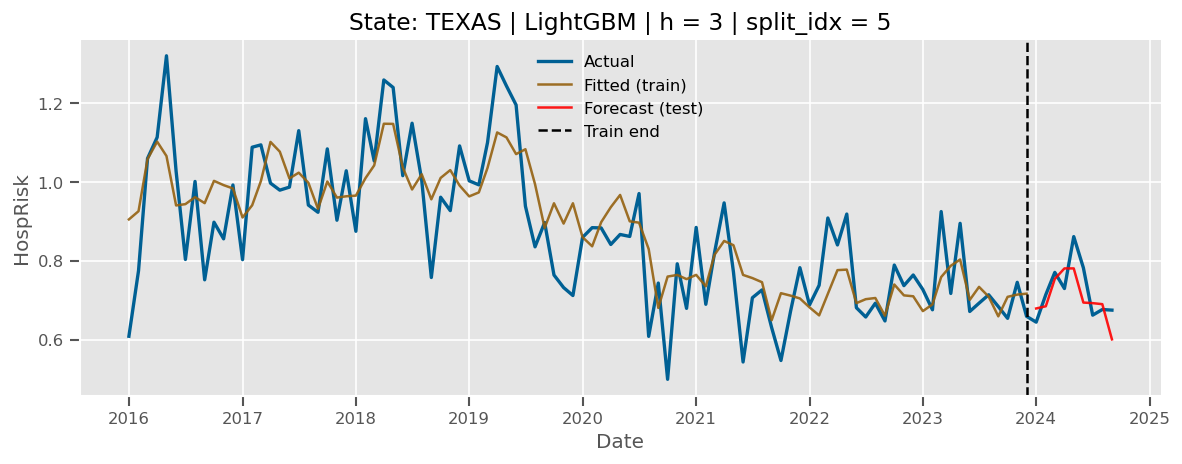

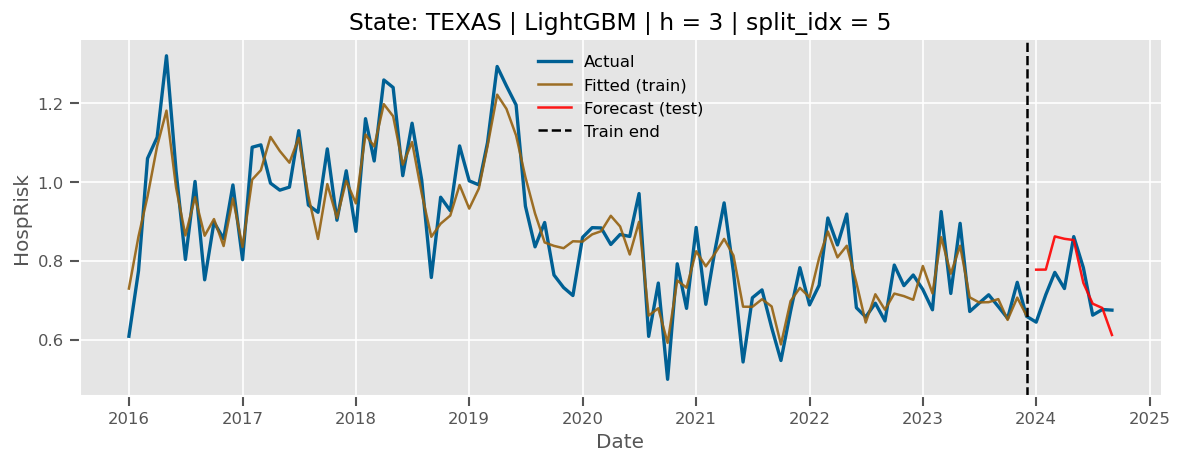

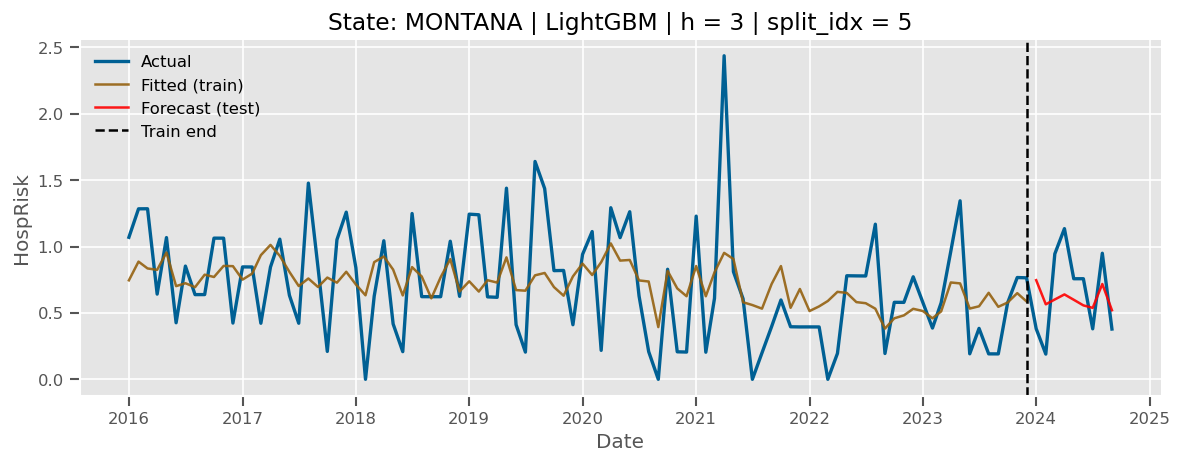

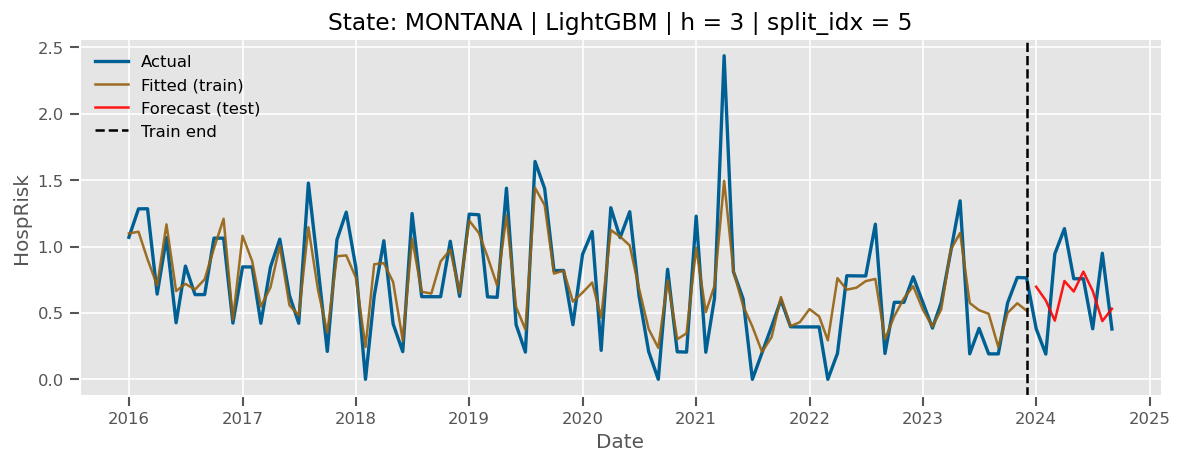

In [108]:
def plot_state_global_vs_local(
    global_preds: pd.DataFrame,
    local_preds: pd.DataFrame,
    *,
    model: str,
    split_idx: int,
    horizon: int,
    state: str,
):
    plot_fit_and_forecast(global_preds, model=model, split_idx=split_idx, horizon=horizon, state=state)
    plot_fit_and_forecast(local_preds,  model=model, split_idx=split_idx, horizon=horizon, state=state)

for st in ["TEXAS", "MONTANA"]:
    plot_state_global_vs_local(
        global_preds, preds_local,
        model="LightGBM",
        split_idx=5,
        horizon=3,
        state=st,
    )


In [122]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_fit_forecast_local_vs_global(
    global_preds: pd.DataFrame,
    local_preds: pd.DataFrame,
    model: str,
    *,
    split_idx: int = 0,
    horizon: int = 3,
    state: str | None = None,     # None -> national mean, else single state
    colors: dict | None = None,   # optional override
):
    """
    Plot Actual + (Global vs Local) fitted & forecast on the same figure.

    - state=None  -> national mean (mean across states)
    - state=str   -> single state series
    """

    # consistent colors (override-able)
    if colors is None:
        colors = {"Global": "#A44148", "Local": "#186d1f"}  # matplotlib default blue/orange

    # stack
    g = global_preds.copy()
    l = local_preds.copy()
    g["strategy"] = "Global"
    l["strategy"] = "Local"
    df = pd.concat([g, l], ignore_index=True)

    # parse dates
    df["Date"] = pd.to_datetime(df["Date"])
    df["train_end"] = pd.to_datetime(df["train_end"])

    # select split by chronological train_end
    train_ends = sorted(df["train_end"].dropna().unique())
    if split_idx < 0 or split_idx >= len(train_ends):
        raise ValueError(f"split_idx must be in [0, {len(train_ends) - 1}]")
    train_end = train_ends[split_idx]

    # filter slice
    df = df[
        (df["train_end"] == train_end) &
        (df["horizon"] == horizon) &
        (df["model"] == model)
    ].copy()

    if state is not None:
        df = df[df["State"] == state].copy()
        if df.empty:
            raise ValueError(f"No data found for state='{state}' with the given model/horizon/split.")
        title_loc = f"State: {state}"
    else:
        title_loc = "National mean"

    if df.empty:
        raise ValueError("No data found for the given arguments.")

    # --- aggregation (mirrors your original logic) ---
    if state is None:
        # actual (national mean)
        actual = (
            df.groupby("Date", as_index=False)["y_true"]
              .mean()
              .rename(columns={"y_true": "actual"})
              .sort_values("Date")
        )

        # predictions (national mean) for each strategy and set
        pred = (
            df.groupby(["strategy", "set", "Date"], as_index=False)["y_pred"]
              .mean()
              .rename(columns={"y_pred": "pred"})
        )
    else:
        # actual (single state)
        actual = (
            df[["Date", "y_true"]]
            .drop_duplicates(subset=["Date"])
            .rename(columns={"y_true": "actual"})
            .sort_values("Date")
        )

        pred = (
            df[["strategy", "set", "Date", "y_pred"]]
            .rename(columns={"y_pred": "pred"})
            .sort_values(["strategy", "set", "Date"])
        )

    # --- plot ---
    plt.figure(figsize=(10, 4))
    plt.plot(actual["Date"], actual["actual"], label="Actual", linewidth=1)

    for strat in ["Global", "Local"]:
        d = pred[pred["strategy"] == strat]

        fitted = d[d["set"] == "train"].sort_values("Date")
        forecast = d[d["set"] == "test"].sort_values("Date")

        if not fitted.empty:
            plt.plot(
                fitted["Date"], fitted["pred"],
                label=f"{strat} fitted",
                color=colors[strat],
                linewidth=1.8,
                alpha=0.9,
            )
        if not forecast.empty:
            plt.plot(
                forecast["Date"], forecast["pred"],
                label=f"{strat} forecast",
                color=colors[strat],
                linestyle="--",
                linewidth=2.0,
                alpha=0.9,
            )

    plt.axvline(train_end, linestyle="--", color="gray", label="Train end")

    plt.title(f"{title_loc} | {model} | h = {horizon} | split_idx = {split_idx}")
    plt.xlabel("Date")
    plt.ylabel("HospRisk")
    plt.legend()
    plt.tight_layout()
    plt.show()


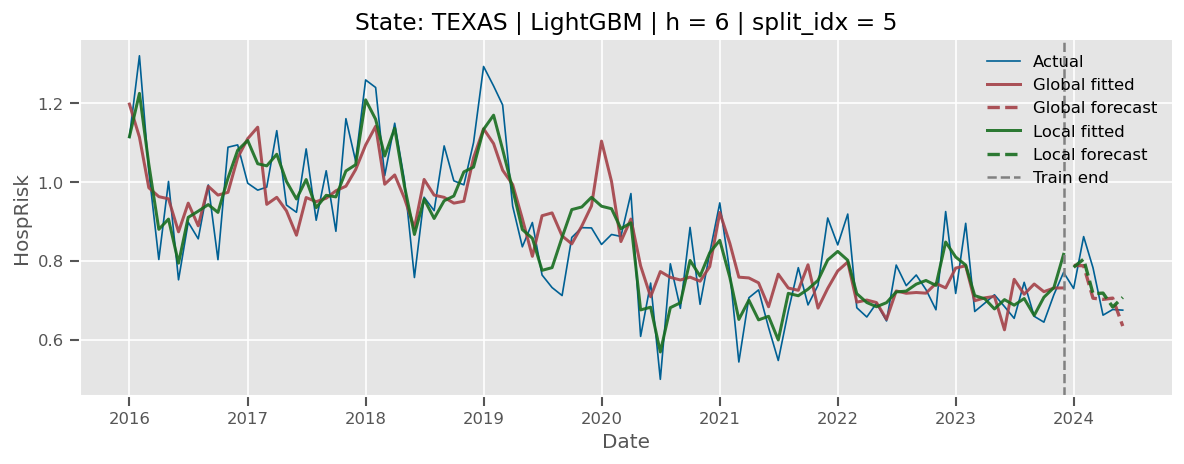

In [135]:
plot_fit_forecast_local_vs_global(
    global_preds, preds_local,
    model="LightGBM",
    split_idx=5,
    horizon=6,
    state="TEXAS",
)


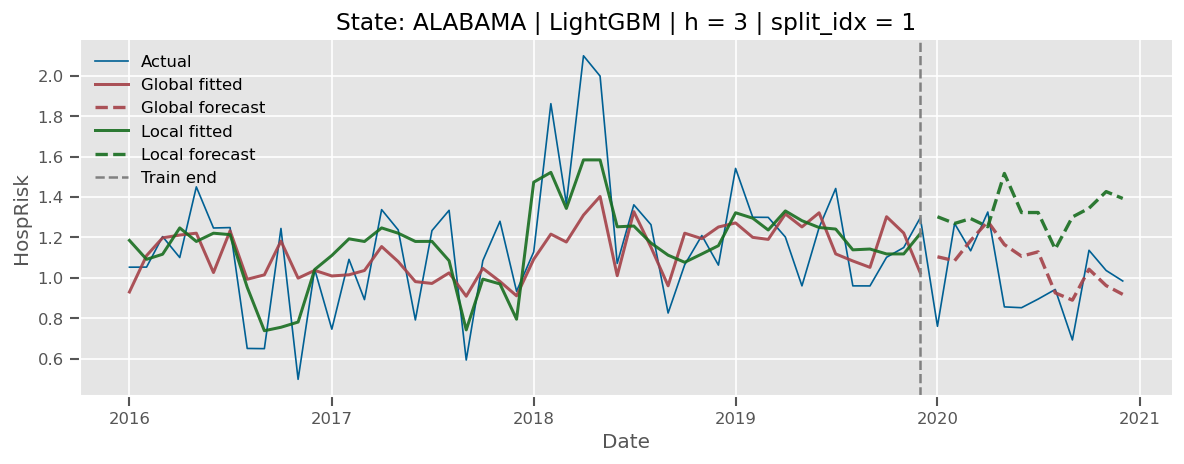

In [134]:
plot_fit_forecast_local_vs_global(
    global_preds, preds_local,
    model='LightGBM',
    split_idx=1,
    horizon=3,
    state='ALABAMA'
)

In [137]:
state_metrics.head()

,State,split_id,train_end,horizon,model,set,n,mae,rmse,mase
0,ALABAMA,1,2018-12-01,1,CatBoost,test,12,0.192100,0.274749,0.576705
1,ALABAMA,1,2018-12-01,1,CatBoost,train,36,0.060731,0.074914,0.182320
2,ALABAMA,1,2018-12-01,1,ElasticNet,test,12,0.368414,0.432646,1.106016
3,ALABAMA,1,2018-12-01,1,ElasticNet,train,36,0.174110,0.213139,0.522696
4,ALABAMA,1,2018-12-01,1,Lasso,test,12,0.341977,0.407578,1.026652


In [145]:
m_split_local = m_split_local.rename(columns={'rmse':'RMSE'})

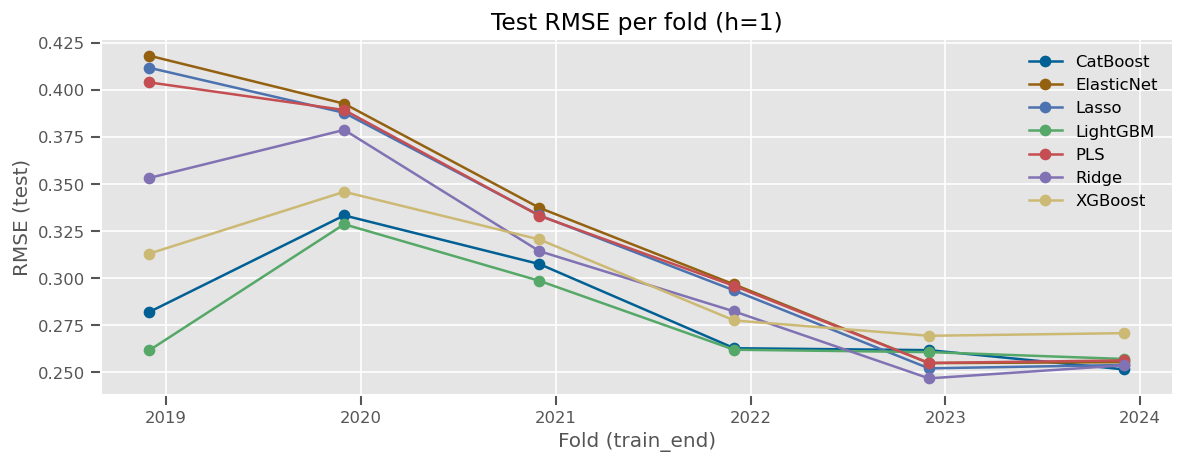

In [146]:
plot_rmse_per_fold(m_split_local, horizon=1)

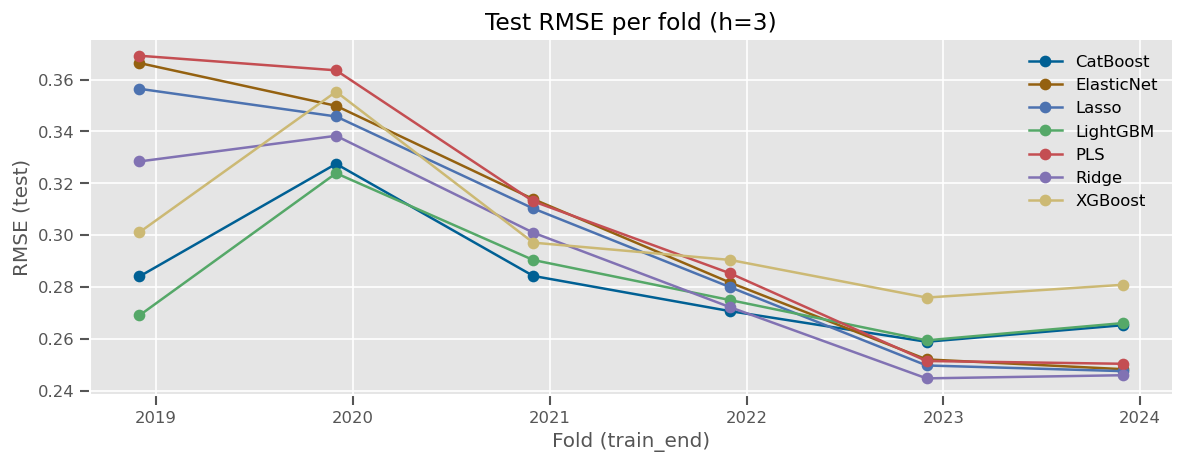

In [147]:
plot_rmse_per_fold(m_split_local, horizon=3)

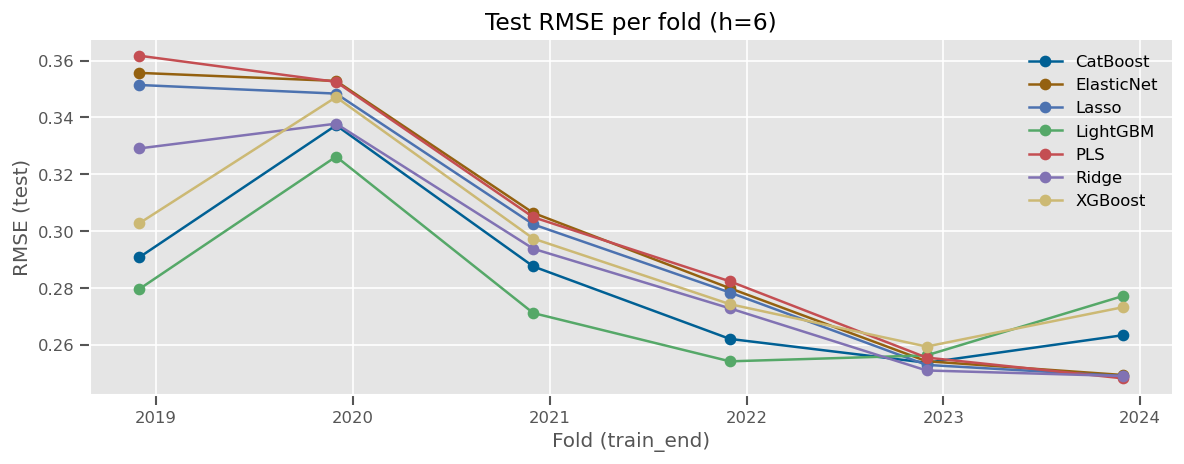

In [148]:
plot_rmse_per_fold(m_split_local, horizon=6)